# Pixel sampling

One of the fundamental issues with expressing planetary and stellar surface intensities or albedos as a spherical harmonic expansion is that it can be difficult to enforce positivity of the surface map everywhere. In particular, there's no way to exactly express the positivity constraint as a prior probability distribution on the spherical harmonic coefficientss. This is a problem not only because the posterior will have support for unphysical solutions, but (more importantly) because a non-negativity prior can be very constraining, greatly reducing the number of degeneracies in the problem.

The approach we recommend here is to **perform the sampling in pixel space, but evaluate the model in spherical harmonic space.** This combines the best of both worlds: pixel space makes it easy to impose physical constraints on the intensity, while in spherical harmonic space the flux evaluation is analytic, fast, and differentiable. Plus, it's easy to construct linear operators that take us back and forth between these two spaces (at some finite resolution).

In [1]:
%matplotlib inline

In [2]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pymc3 as pm
import pymc3_ext as pmx
import theano
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)

if starry.compat.USE_AESARA:
    theano_config = dict(aesara_config=dict(compute_test_value="ignore"))
else:
    theano_config = dict(theano_config=dict(compute_test_value="ignore"))

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mock data

Let's first generate a mock dataset so we can experiment with.

### Mock surface map

We'll create a stellar (or planetary) surface map with several large, distinct spots. We'll do this at high ($l=20$) resolution so we can get crisp features without significant ringing. Note that we set the inclination to $85^\circ$ so we can break the north-south degeneracy from map viewed edge-on.

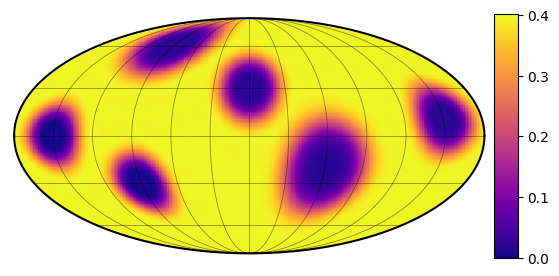

In [3]:
# Params
ydeg_tru = 20
inc = 85

# Instantiate
map_tru = starry.Map(ydeg_tru, inc=inc)
map_tru.add_spot(amp=-0.03, relative=False, sigma=0.05, lat=30, lon=0)
map_tru.add_spot(amp=-0.06, relative=False, sigma=0.1, lat=-20, lon=60)
map_tru.add_spot(amp=-0.03, relative=False, sigma=0.05, lat=10, lon=150)
map_tru.add_spot(amp=-0.03, relative=False, sigma=0.05, lat=60, lon=-90)
map_tru.add_spot(amp=-0.025, relative=False, sigma=0.04, lat=-30, lon=-90)
map_tru.add_spot(amp=-0.025, relative=False, sigma=0.04, lat=0, lon=-150)
map_tru.amp = 1.0
y_tru = np.array(map_tru.y.eval())
amp_tru = 1.0
map_tru.show(projection="moll", colorbar=True, norm=cnorm(), cmap=cmap)

### Mock light curve

In [4]:
starry.config.lazy = True
starry.config.quiet = True
rp_true = 0.1
porb = 2
t0 = 0.5
mp = 6e-4
ecc=0.0
u1 = 0.40
u2 = 0.26

star = starry.Primary(map_tru, m=1.0, r=1.0, prot=10.0)

planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=mp,  # mass in solar masses
    r=rp_true,  # radius in solar radii
    w=100,
    porb=porb,  # orbital period in days
    ecc=ecc,  # eccentricity
    t0=t0,  # time of transit in days
)
system = starry.System(star, planet)

Now let's generate a mock light curve. As our object rotates, we'll transit it with several occultors of different sizes and at different impact parameters. This isn't necessarily realistic, but the point here is to ensure our light curve encodes information about the map at a variety of positions and a variety of scales.

We begin by constructing the flux design matrix, which dots into the spherical harmonic coefficient vector to give us the flux:

In [5]:
# Params
npts = 1000
prot = 10.0 #/ 7.0
# bo = [-0.5, 0.25, 0.75, 0.5]
bo=[0.5]
ro=[0.1]
# ro = [0.5, 0.75, 0.3, 0.2]
time = np.linspace(0, 10, npts)
theta = (360.0 * time / prot).reshape(len(ro), -1)
xo, yo, zo = system.position(time)
xo = xo[1]
yo = yo[1]
zo = zo[1]
X_tru = np.vstack(
    [
        map_tru.design_matrix(
            theta=theta[i],
            # xo=np.linspace(-1 - ro[i], 1 + ro[i], len(theta[i])),
            xo=xo,
            # yo=bo[i],
            yo=yo,
            ro=rp_true,
            # ro=ro[i],
        ).eval()
        for i in range(1)
    ]
)

Now we generate the light curve, add a tiny bit of noise, and median-normalize it.

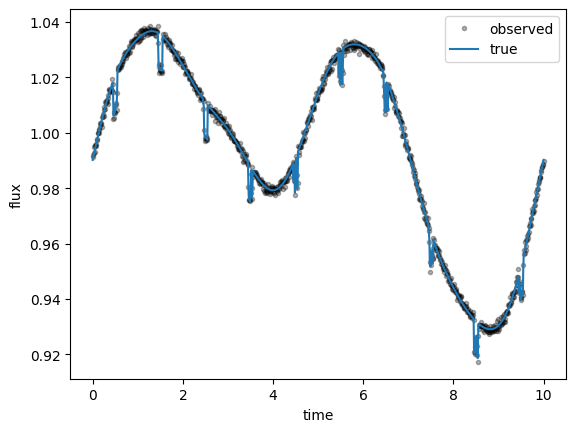

In [6]:
# Generate the light curve
flux_tru = amp_tru * X_tru.dot(y_tru)

# Add noise
np.random.seed(0)
ferr_tru = 1e-3
flux = flux_tru + ferr_tru * np.random.randn(len(flux_tru))

# Normalize
norm = np.nanmedian(flux)
flux = flux / norm
ferr = ferr_tru / norm

# Plot
plt.plot(time, flux, "k.", alpha=0.3, label="observed")
plt.plot(time, flux_tru / norm, "C0", label="true")
plt.legend()
plt.xlabel("time")
plt.ylabel("flux");

## Inference

It's time to do inference. For simplicity, we'll assume we know all the information about the occultors and the object's rotation rate **exactly**, so the only unknown is the surface map.

We'll begin by pre-computing some of the linear operators we'll use throughout this notebook:

In [7]:
# Params
ydeg_inf = 15

# Instantiate
map_inf = starry.Map(ydeg_inf, inc=inc)
X_inf = X_tru[:, : (ydeg_inf + 1) ** 2]
lat, lon, Y2P, P2Y, Dx, Dy = map_inf.get_pixel_transforms(oversample=2)
npix = lat.shape[0]

We'll discuss these in more detail below, but `X_inf` is our design matrix at the resolution we're doing inference at, `Y2P` and `P2Y` are the linear operators that transform back and forth between spherical harmonic coefficients and pixel intensities, and `Dx` and `Dy` are the numerical derivative operators, which dot into a vector of pixel intensities to produce the vector of $x$- and $y$-derivatives at those pixels.

We'll consider various inference methods below. Let's store all our solutions in these variables:

In [8]:
nmeth = 7
labels = ["L2", "U", "Beta", "U+Mix", "U+TV", "Aizawa", "U+TV+Mix"]
y = np.zeros((nmeth, (ydeg_inf + 1) ** 2))
amp = np.zeros(nmeth)
flux_model = np.zeros((nmeth, npts))

In [9]:
def plot(y, amp, flux_model):
    """
    Compare the inferred map to the true map.

    """
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(wspace=0.15)
    ax = [
        plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
        plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
        plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1),
        plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1),
    ]

    # Show the true map
    map_tru.show(
        ax=ax[0],
        projection="moll",
        colorbar=True,
        norm=cnorm(),
        cmap=cmap,
    )

    # Show the inferred map
    map_inf.amp = amp
    map_inf[1:, :] = y[1:]
    map_inf.show(
        ax=ax[1],
        projection="moll",
        colorbar=True,
        norm=cnorm(),
        cmap=cmap,
    )

    # Show the flux model
    ax[2].plot(time, flux, "k.", alpha=0.3, label="observed")
    ax[2].plot(time, flux_model, "C1", label="model")
    ax[2].legend(fontsize=10, loc="lower right")
    ax[2].set_xlabel("time")
    ax[2].set_ylabel("flux")

    # Show the pixel distributions
    pix_tru = map_tru.render(projection="moll").eval().flatten()
    pix_tru /= np.nanmax(pix_tru)
    pix_tmp = map_inf.render(projection="moll").eval().flatten()
    pix_tmp /= np.nanmax(pix_tmp)
    ax[3].hist(pix_tru, bins=50, alpha=0.5, label="true")
    ax[3].hist(pix_tmp, bins=50, alpha=0.5, label="inferred")
    ax[3].legend()
    ax[3].set_yticks([])
    ax[3].set_ylabel("pixels")
    ax[3].set_xlabel("intensity");

### L2 inference

Our first method is the usual one: L2 regularization on the spherical harmonic coefficients. The posterior is analytic and so we don't need to do any sampling. The only thing we need to decide on is the prior on the coefficients, which for simplicity we'll assume is a zero-mean Gaussian with covariance that's a scalar multiple of the identity. We just need to choose that scalar, which we'll call $\lambda$. If we make $\lambda$ small enough, we  actually **can** ensure the map is positive everywhere, since we're severely restricting the variability of the features about the mean (which is non-zero). 

In [10]:
map_inf.set_data(flux, C=ferr ** 2)
map_inf.set_prior(L=1e-4)
map_inf.solve(design_matrix=X_inf)
y[0] = np.array(map_inf.y.eval())
amp[0] = map_inf.amp.eval()
flux_model[0] = amp[0] * X_inf.dot(y[0])

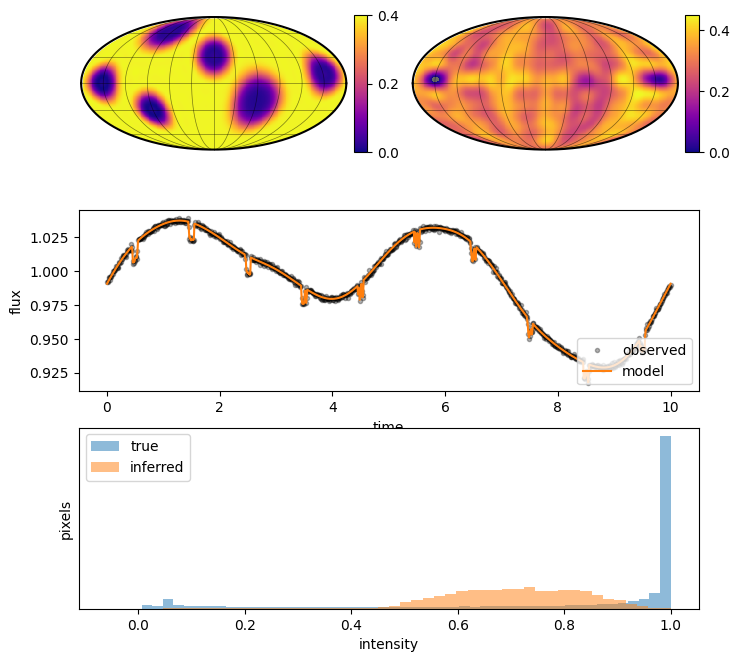

In [11]:
plot(y[0], amp[0], flux_model[0])

### Pixel inference w/ uniform prior

Now let's instead sample in pixel space. We place a uniform prior on the pixels, then transform to spherical harmonics via the `P2Y` matrix, and use those to compute the flux. Note that the posterior we care about is *still* over the spherical harmonic coefficients, since that is the space in which we are computing the light curve model. The pixel sampling is merely a trick so we can enforce our prior.

In [12]:
with pm.Model(**theano_config) as model:

    # Uniform prior on the *pixels*
    p = pm.Uniform("p", lower=0.0, upper=1.0, shape=(npix,))
    norm = pm.Normal("norm", mu=0.5, sd=0.25)
    x = norm * tt.dot(P2Y, p)

    # Compute the flux
    lc_model = tt.dot(X_inf, x)
    pm.Deterministic("lc_model", lc_model)
    lc_model_guess = pmx.eval_in_model(lc_model)

    # Store the Ylm coeffs. Note that `x` is the
    # *amplitude-weighted* vector of spherical harmonic
    # coefficients.
    pm.Deterministic("amp", x[0])
    pm.Deterministic("y", x / x[0])

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=ferr, observed=flux)

In [13]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y[1] = np.array(soln["y"])
    amp[1] = soln["amp"]
    flux_model[1] = soln["lc_model"]

message: Desired error not necessarily achieved due to precision loss.
logp: -21504791.782194234 -> 4691.425393315401


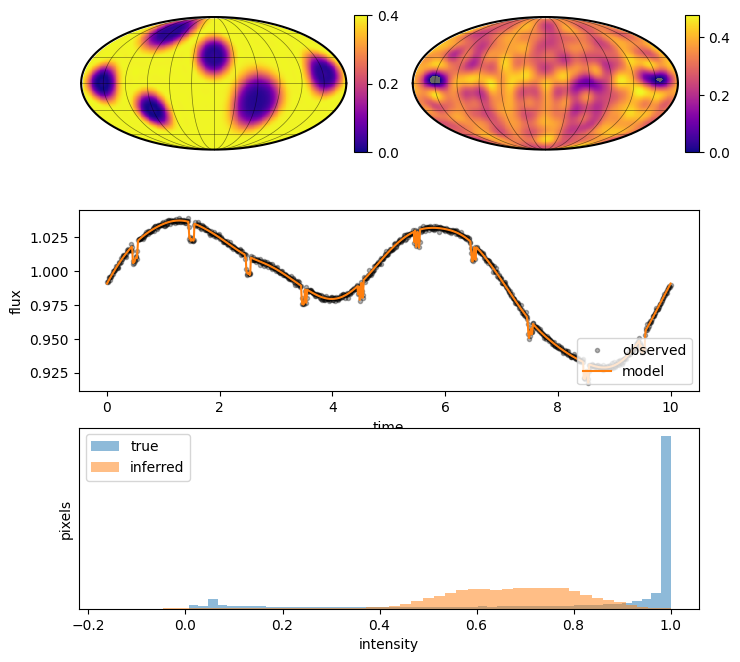

In [14]:
plot(y[1], amp[1], flux_model[1])

## Pixel inference w/ Beta prior

Looking at the histogram of true pixel intensities above, it looks like we may be able to capture this behavior with a $Beta(0.5, 0.5)$ prior, which places most of it weight at 0 and 1. Let's try that and see what happens:

In [15]:
with pm.Model(**theano_config) as model:

    # Beta prior on the *pixels*
    p = pm.Beta("p", alpha=0.5, beta=0.5, shape=(npix,))
    norm = pm.Normal("norm", mu=0.5, sd=0.25)
    x = norm * tt.dot(P2Y, p)

    # Compute the flux
    lc_model = tt.dot(X_inf, x)
    pm.Deterministic("lc_model", lc_model)
    lc_model_guess = pmx.eval_in_model(lc_model)

    # Store the Ylm coeffs
    pm.Deterministic("amp", x[0])
    pm.Deterministic("y", x / x[0])

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=ferr, observed=flux)

In [16]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y[2] = np.array(soln["y"])
    amp[2] = soln["amp"]
    flux_model[2] = soln["lc_model"]

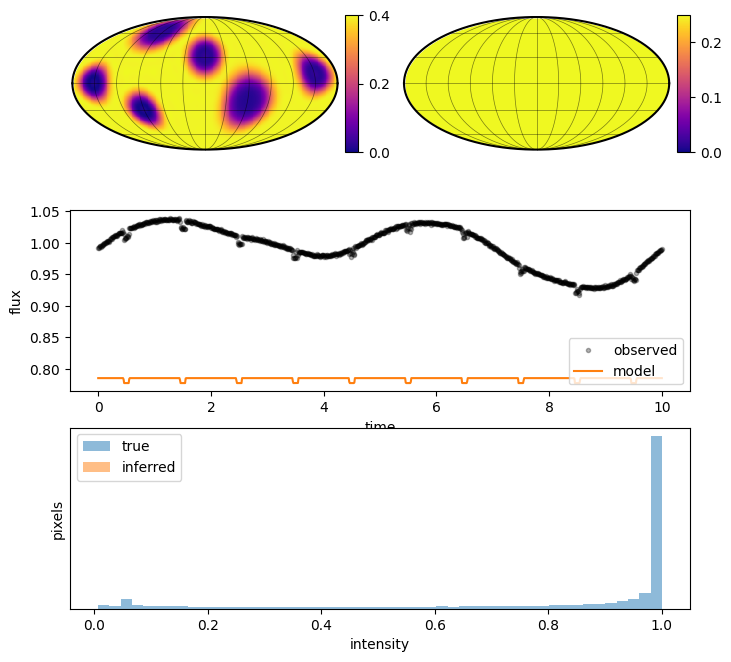

In [17]:
plot(y[2], amp[2], flux_model[2])

## Pixel inference w/ Gaussian mixture prior

We could also try a Gaussian mixture model to place weight at the two extrema:

In [18]:
with pm.Model(**theano_config) as model:

    # Uniform prior on the *pixels*
    p = pm.Uniform(
        "p", lower=0.0, upper=1.0, shape=(npix,), testval=0.99 * np.ones(npix)
    )
    norm = pm.Normal("norm", mu=0.5, sd=0.25)
    x = norm * tt.dot(P2Y, p)

    # Mixture of Gaussians
    sig = 0.35
    pm.Potential("mix", -0.5 * tt.sum(tt.minimum((1 - p) ** 2, (p ** 2))) / sig ** 2)

    # Compute the flux
    lc_model = tt.dot(X_inf, x)
    pm.Deterministic("lc_model", lc_model)
    lc_model_guess = pmx.eval_in_model(lc_model)

    # Store the Ylm coeffs
    pm.Deterministic("amp", x[0])
    pm.Deterministic("y", x / x[0])

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=ferr, observed=flux)

In [19]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y[3] = np.array(soln["y"])
    amp[3] = soln["amp"]
    flux_model[3] = soln["lc_model"]

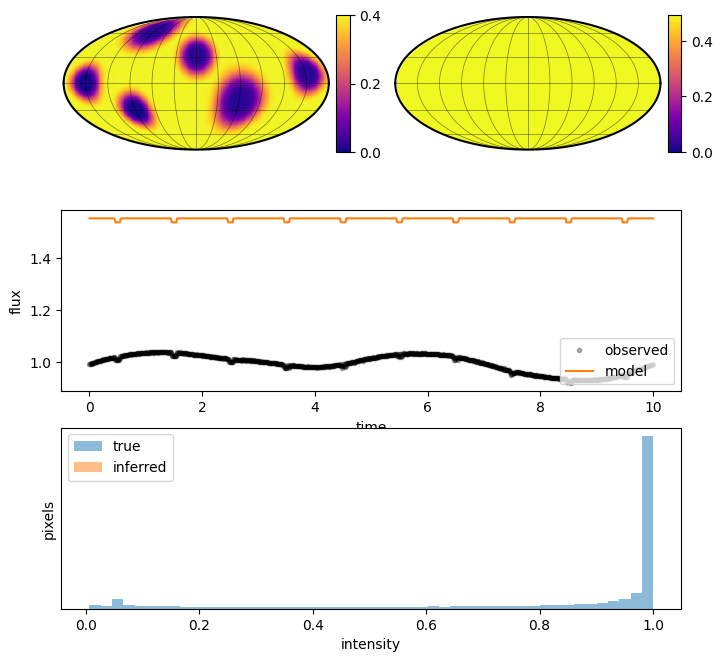

In [20]:
plot(y[3], amp[3], flux_model[3])

## Pixel inference w/ TV prior

Place a total variation (TV) L1 prior on the magnitude of the gradient:

In [21]:
with pm.Model(**theano_config) as model:

    # Uniform prior on the *pixels*
    p = pm.Uniform("p", lower=0.0, upper=1.0, shape=(npix,))
    norm = pm.Normal("norm", mu=0.5, sd=0.25)
    x = norm * tt.dot(P2Y, p)

    # Apply the TV penalty
    theta = 0.1
    TV = tt.sum(tt.sqrt(tt.dot(Dx, p) ** 2 + tt.dot(Dy, p) ** 2))
    pm.Potential("TV", -TV / theta)

    # Compute the flux
    lc_model = tt.dot(X_inf, x)
    pm.Deterministic("lc_model", lc_model)
    lc_model_guess = pmx.eval_in_model(lc_model)

    # Store the Ylm coeffs
    pm.Deterministic("amp", x[0])
    pm.Deterministic("y", x / x[0])

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=ferr, observed=flux)

In [22]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y[4] = np.array(soln["y"])
    amp[4] = soln["amp"]
    flux_model[4] = soln["lc_model"]

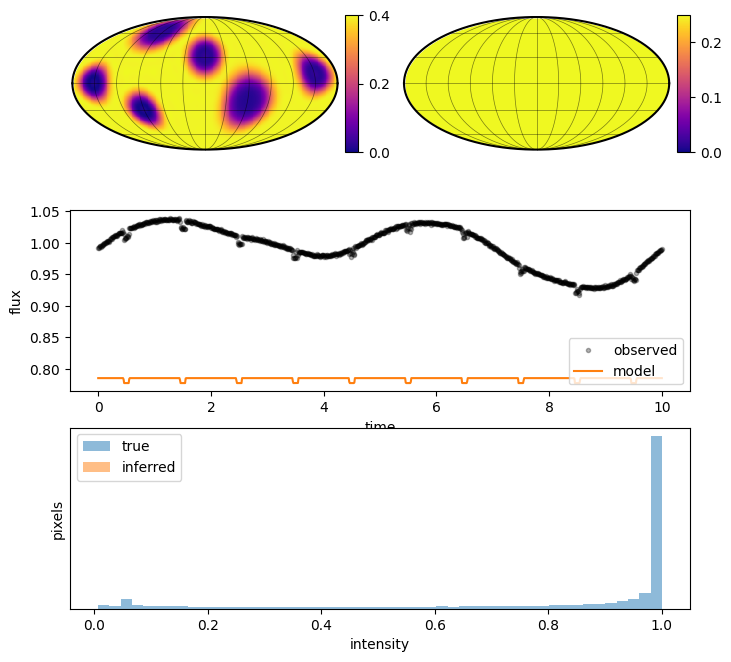

In [23]:
plot(y[4], amp[4], flux_model[4])

## Pixel inference w/ [Aizawa+20](https://arxiv.org/pdf/2004.03941.pdf) prior

In [24]:
with pm.Model(**theano_config) as model:

    # Uniform prior on the *pixels*
    p = pm.Uniform("p", lower=0.0, upper=1.0, shape=(npix,))
    norm = pm.Normal("norm", mu=0.5, sd=0.25)
    x = norm * tt.dot(P2Y, p)

    # Apply the L1 penalty on the
    # *difference between the pixels and unity*
    # since we want sparseness relative to the
    # background flux (which is unity)
    lam = 1.0
    pm.Potential("L1", -lam * tt.sum(tt.abs_((1 - p))))

    # Apply the TSV penalty as an L2 norm on the gradient
    sig = 0.5
    pm.Potential(
        "TSV", -0.5 * tt.sum((tt.dot(Dx, p)) ** 2 + (tt.dot(Dy, p)) ** 2) / sig ** 2
    )

    # Compute the flux
    lc_model = tt.dot(X_inf, x)
    pm.Deterministic("lc_model", lc_model)
    lc_model_guess = pmx.eval_in_model(lc_model)

    # Store the Ylm coeffs
    pm.Deterministic("amp", x[0])
    pm.Deterministic("y", x / x[0])

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=ferr, observed=flux)

In [25]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y[5] = np.array(soln["y"])
    amp[5] = soln["amp"]
    flux_model[5] = soln["lc_model"]

message: Desired error not necessarily achieved due to precision loss.
logp: -21505079.782194234 -> 4238.176673365783


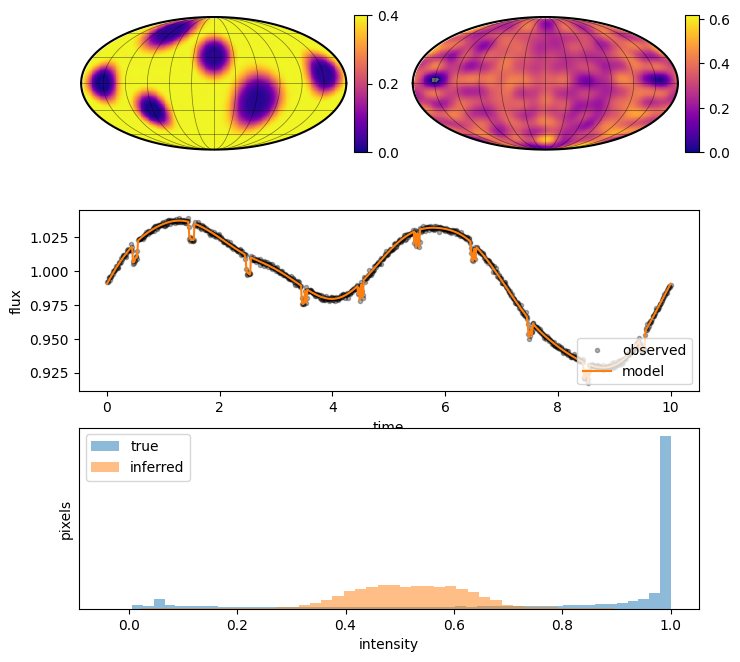

In [26]:
plot(y[5], amp[5], flux_model[5])

## Pixel inference w/ TV + Gaussian mixture prior

In [27]:
with pm.Model(**theano_config) as model:

    # Uniform prior on the *pixels*
    # Initialize at the solution to the mixture model run
    guess = amp[3] * np.maximum(0, np.dot(Y2P, y[3]))
    scale = np.max(guess)
    pad = 1e-2
    guess = pad + guess / scale * (1 - 2 * pad)
    p = pm.Uniform("p", lower=0.0, upper=1.0, shape=(npix,), testval=guess)
    norm = pm.Normal("norm", mu=0.5, sd=0.25, testval=scale)
    x = norm * tt.dot(P2Y, p)

    # Mixture of Gaussians
    sig = 0.35
    pm.Potential("mix", -0.5 * tt.sum(tt.minimum((1 - p) ** 2, (p ** 2))) / sig ** 2)

    # Apply the TV penalty
    theta = 3.0
    TV = tt.sum(tt.sqrt(tt.dot(Dx, p) ** 2 + tt.dot(Dy, p) ** 2))
    pm.Potential("TV", -TV / theta)

    # Compute the flux
    lc_model = tt.dot(X_inf, x)
    pm.Deterministic("lc_model", lc_model)
    lc_model_guess = pmx.eval_in_model(lc_model)

    # Store the Ylm coeffs
    pm.Deterministic("amp", x[0])
    pm.Deterministic("y", x / x[0])

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=ferr, observed=flux)

In [28]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y[6] = np.array(soln["y"])
    amp[6] = soln["amp"]
    flux_model[6] = soln["lc_model"]

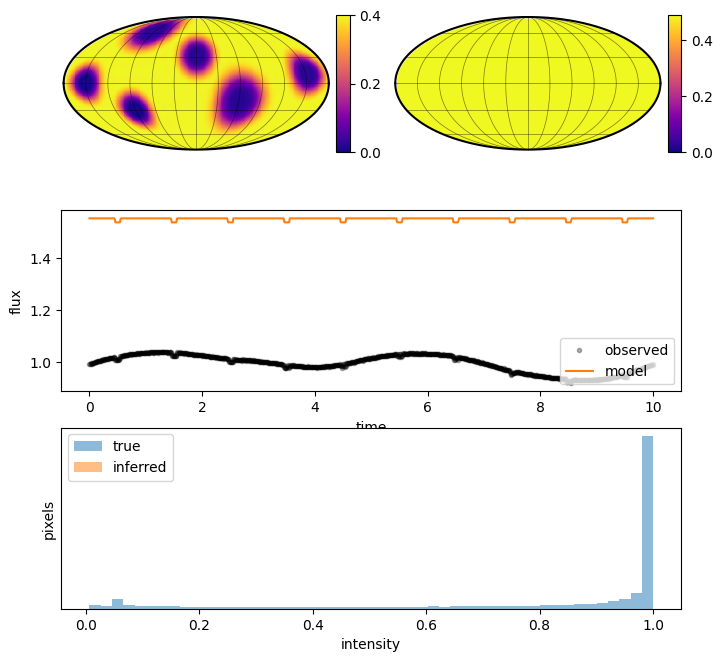

In [29]:
plot(np.array(soln["y"]), soln["amp"], flux_model[3])

## Compare all the methods

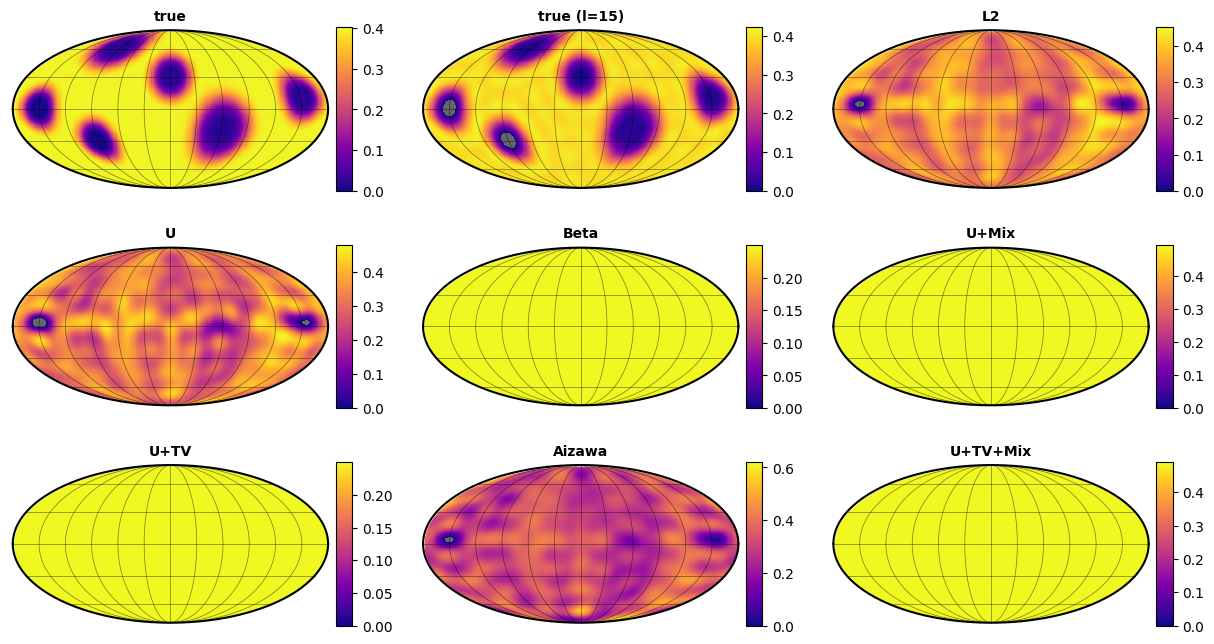

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
ax = ax.flatten()
for axis in ax:
    axis.axis("off")

# True map
map_tru.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
    norm=cnorm(),
    cmap=cmap,
)
ax[0].annotate(
    "true",
    xy=(0, np.sqrt(2)),
    xycoords="data",
    xytext=(0, 5),
    textcoords="offset points",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold",
)

# True map at inference resolution
map_inf.amp = amp_tru
map_inf[1:, :] = y_tru[1 : (ydeg_inf + 1) ** 2]
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
    norm=cnorm(),
    cmap=cmap,
)
ax[1].annotate(
    "true (l={})".format(ydeg_inf),
    xy=(0, np.sqrt(2)),
    xycoords="data",
    xytext=(0, 5),
    textcoords="offset points",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold",
    clip_on=False,
)

# Inferred maps
for i in range(nmeth):
    map_inf.amp = amp[i]
    map_inf[1:, :] = y[i][1:]
    map_inf.show(
        ax=ax[i + 2],
        projection="moll",
        colorbar=True,
        norm=cnorm(),
        cmap=cmap,
    )
    ax[i + 2].annotate(
        labels[i],
        xy=(0, np.sqrt(2)),
        xycoords="data",
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        clip_on=False,
    )